# __Using PCA after ridge and lasso regression to reduce dimensionality and improve interpretability of the model.__

In [8]:
import pandas as pd

%store -r regularization

# Create an empty dictionary to store the datasets
dataset = {}

# Iterate over the rows of the regularization dataframe
for axis, weights in regularization.iterrows():
    
    # Extract the Lasso weights for the current axis
    lasso_weights = weights['Lasso Weight']
    
    # Read the cleaned dataset from the CSV file
    cleaned_dataset = pd.read_csv('cleaned_dataset.csv')
    
    # Determine the column to move based on the current axis
    if axis == 'X':
        column_to_move = 'SHUTTLECOCK POSITIION IN AIR(X) metres'
    elif axis == 'Y':
        column_to_move = 'SHUTTLECOCK POSITIION IN AIR(Y) metres'
    else:
        column_to_move = 'SHUTTLECOCK POSITIION IN AIR(Z) metres'
    
    # Reorder the columns, moving the column_to_move to the end
    cleaned_dataset = cleaned_dataset[[column for column in cleaned_dataset.columns if column != column_to_move] + [column_to_move]]
    
    # Identify the columns to delete based on Lasso weights
    columns_to_delete = [index for index, weight in enumerate(lasso_weights) if weight == 0]
    
    # Drop the columns to be deleted from the cleaned dataset
    dataset[axis] = cleaned_dataset.drop(cleaned_dataset.columns[columns_to_delete], axis=1)
    
    # Print the dataset for the current axis
    print(f'Dataset for {axis}:')
    print(dataset[axis].head(3).to_string(index=False))
    print()


Dataset for X:
 HUMAN PLAYER POSITION (Y) metres  INITITAL VELOCITY OF SHUTTELCOCK(m/s)  INITIAL SHUTTELCOCK FIRING ANGLE (DEGREE)  SHUTTELCOCK SLANT ANGLE TO SIDELINE(DEGREE)  SHUTTLECOCK POSITIION IN AIR(Y) metres  SHUTTLECOCK POSITIION IN AIR(Z) metres  SHUTTLECOCK POSITIION IN AIR(X) metres
                                1                                     10                                         40                                            0                                     1.0                                1.662912                                4.075543
                                1                                     10                                         40                                            0                                     1.0                                1.724866                                4.152007
                                1                                     10                                         40                           

__Standardization Step in PCA__

The standardization step in PCA involves transforming the data by scaling it to have zero mean and unit variance. This step is important because it helps to bring all the variables to a common scale, ensuring that no variable dominates the analysis based on its magnitude. Standardizing the data is a necessary preprocessing step before performing PCA.

In [3]:
from sklearn.preprocessing import StandardScaler

# Create an empty dictionary to store the standardized datasets
standardized_data = {}

# Iterate over the items (key-value pairs) in the dataset dictionary
for key, data in dataset.items():
    # Create a StandardScaler object
    scaler = StandardScaler()
    
    # Fit the scaler to the data and compute the mean and standard deviation
    scaler.fit(data)
    
    # Standardize the data using the computed mean and standard deviation
    standardized_data[key] = pd.DataFrame(scaler.transform(data), columns=dataset[key].columns)
    
    # Print the standardized dataset for the current key
    print(f'Standardized dataset for {key}:')
    print(standardized_data[key].head(3).to_string(index=False))
    print()


Standardized dataset for X:
 HUMAN PLAYER POSITION (Y) metres  INITITAL VELOCITY OF SHUTTELCOCK(m/s)  INITIAL SHUTTELCOCK FIRING ANGLE (DEGREE)  SHUTTELCOCK SLANT ANGLE TO SIDELINE(DEGREE)  SHUTTLECOCK POSITIION IN AIR(Y) metres  SHUTTLECOCK POSITIION IN AIR(Z) metres  SHUTTLECOCK POSITIION IN AIR(X) metres
                        -1.317609                              -0.372838                                  -1.240338                                     -0.12118                               -0.734188                               -1.628600                               -2.025397
                        -1.317609                              -0.372838                                  -1.240338                                     -0.12118                               -0.734188                               -1.591047                               -1.975909
                        -1.317609                              -0.372838                                  -1.240338              

__Computing the Covariance Matrix in PCA__

The computation of the covariance matrix is a crucial step in PCA. The covariance matrix provides information about the relationships and dependencies between variables in the dataset. It is used to identify the correlations between different variables and determine the principal components.

In [4]:
# Create an empty dictionary to store the covariance matrices
covariance_matrices = {}

# Iterate over the items (key-value pairs) in the standardized_data dictionary
for key, dataset in standardized_data.items():
    # Compute the covariance matrix for the current dataset
    covariance_matrices[key] = dataset.cov()

    # Print the covariance matrix for the current key
    print(f'Covariance matrix for {key}:')
    print(covariance_matrices[key].to_string(index=False, header=False))
    print()


Covariance matrix for X:
 1.000006 -0.012939  0.014684 -0.044561  0.462118  0.017747 -0.003405
-0.012939  1.000006  0.547520  0.000668 -0.002325  0.327885  0.063759
 0.014684  0.547520  1.000006  0.023523  0.021196  0.440457 -0.094461
-0.044561  0.000668  0.023523  1.000006  0.773678 -0.039571 -0.008174
 0.462118 -0.002325  0.021196  0.773678  1.000006 -0.017002  0.031920
 0.017747  0.327885  0.440457 -0.039571 -0.017002  1.000006 -0.083498
-0.003405  0.063759 -0.094461 -0.008174  0.031920 -0.083498  1.000006

Covariance matrix for Y:
 1.000006  0.014684 -0.044561 -0.003405 0.462118
 0.014684  1.000006  0.023523 -0.094461 0.021196
-0.044561  0.023523  1.000006 -0.008174 0.773678
-0.003405 -0.094461 -0.008174  1.000006 0.031920
 0.462118  0.021196  0.773678  0.031920 1.000006

Covariance matrix for Z:
1.000006  0.547520  0.000668  0.063759  0.327885
0.547520  1.000006  0.023523 -0.094461  0.440457
0.000668  0.023523  1.000006 -0.008174 -0.039571
0.063759 -0.094461 -0.008174  1.000006 -0

__Computing Eigenvectors and Eigenvalues in PCA__

The computation of eigenvectors and eigenvalues is a crucial step in PCA. Eigenvectors represent the directions or axes along which the data varies the most, while eigenvalues represent the amount of variance explained by each eigenvector.

In [5]:
import numpy as np

# Create empty dictionaries to store eigenvalues and eigenvectors
eigen_values = {}
eigen_vectors = {}

# Iterate over the items (key-value pairs) in the covariance_matrices dictionary
for key, covariance_matrix in covariance_matrices.items():
    # Compute eigenvalues and eigenvectors for the current covariance matrix
    eigen_value, eigen_vector = np.linalg.eig(covariance_matrix)

    # Store the eigenvalues and eigenvectors in the respective dictionaries
    eigen_values[key] = eigen_value
    eigen_vectors[key] = eigen_vector

    # Print the eigenvalues for the current key
    print(f'Eigenvalues for {key}:')
    print(eigen_value)
    print()

    # Print the eigenvectors for the current key
    print(f'Eigenvectors for {key}:')
    print(eigen_vector)
    print()


Eigenvalues for X:
[1.88368751 1.88869507 0.07775053 1.04431456 1.02884747 0.66049365
 0.41625267]

Eigenvectors for X:
[[ 0.33135684  0.08727564 -0.3794183  -0.80076957  0.30220813  0.07747061
   0.00800056]
 [-0.12553173  0.55893664 -0.00221847  0.14689988  0.22326991  0.4811112
   0.60739582]
 [-0.1129679   0.61269     0.00946455  0.01650663 -0.03314601  0.21674126
  -0.75060758]
 [ 0.59619329  0.12611121 -0.60551681  0.46083221 -0.21723732 -0.04806252
   0.01142492]
 [ 0.69681496  0.15610675  0.69870383 -0.02221706  0.01515152 -0.02543228
   0.02286024]
 [-0.13960251  0.50948963 -0.01233219 -0.10573978 -0.08676258 -0.81279979
   0.20353679]
 [ 0.03458759 -0.06878028 -0.03094383  0.33596909  0.89597587 -0.22793252
  -0.15973172]]

Eigenvalues for Y:
[0.07786497 1.88358549 0.90450155 1.03924627 1.09483134]

Eigenvectors for Y:
[[ 0.37970408 -0.3433212   0.03418872 -0.85833457  0.00694705]
 [-0.00226801 -0.0374562  -0.70984951 -0.01998611 -0.70306907]
 [ 0.60516845 -0.60878953  0.0264

__Deriving Feature Vector using PCA__

The feature vector in PCA consists of the principal components that capture the most important information in the data. The principal components are selected based on the desired variance explained by the components. The steps to derive the feature vector are as follows:

<u>Calculate Explained Variance</u>: Compute the explained variance for each principal component. Explained variance represents the percentage of total variance in the data captured by each principal component.

<u>Plot Explained Variance</u>: Visualize the explained variance for each principal component to determine the number of components needed to achieve a desired threshold of variance explained.

<u>Select Principal Components</u>: Determine the number of principal components required to achieve the desired variance threshold and select those components.

<u>Form the Feature Vector</u>: Form the feature vector using the selected principal components, which will represent the reduced feature space for the data.

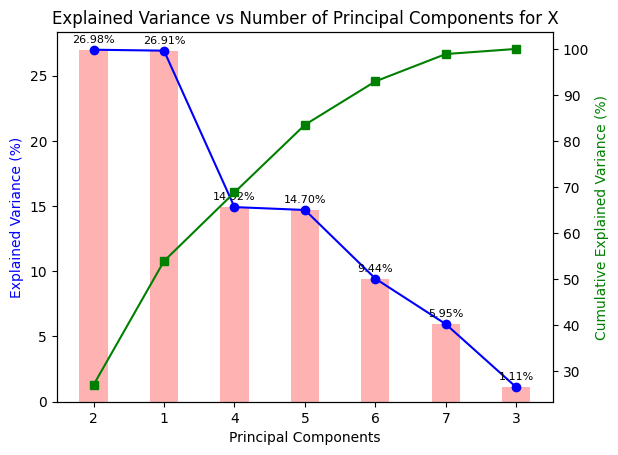

Feature vector for X:
[[ 0.33135684  0.08727564 -0.80076957  0.30220813  0.07747061]
 [-0.12553173  0.55893664  0.14689988  0.22326991  0.4811112 ]
 [-0.1129679   0.61269     0.01650663 -0.03314601  0.21674126]
 [ 0.59619329  0.12611121  0.46083221 -0.21723732 -0.04806252]
 [ 0.69681496  0.15610675 -0.02221706  0.01515152 -0.02543228]
 [-0.13960251  0.50948963 -0.10573978 -0.08676258 -0.81279979]
 [ 0.03458759 -0.06878028  0.33596909  0.89597587 -0.22793252]]
Principal Component(s) to keep for X:
[1 2 4 5 6]


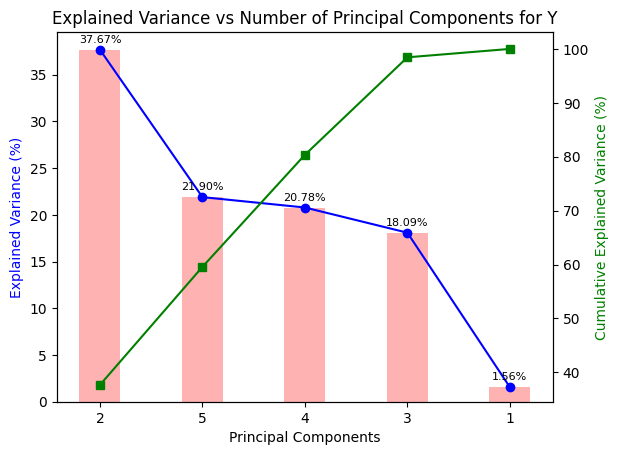

Feature vector for Y:
[[-0.3433212   0.03418872 -0.85833457  0.00694705]
 [-0.0374562  -0.70984951 -0.01998611 -0.70306907]
 [-0.60878953  0.02643874  0.51218298 -0.01077229]
 [-0.01483658 -0.70290852 -0.00271874  0.71045598]
 [-0.71406076  0.01286121 -0.02288074  0.02796197]]
Principal Component(s) to keep for Y:
[2 3 4 5]


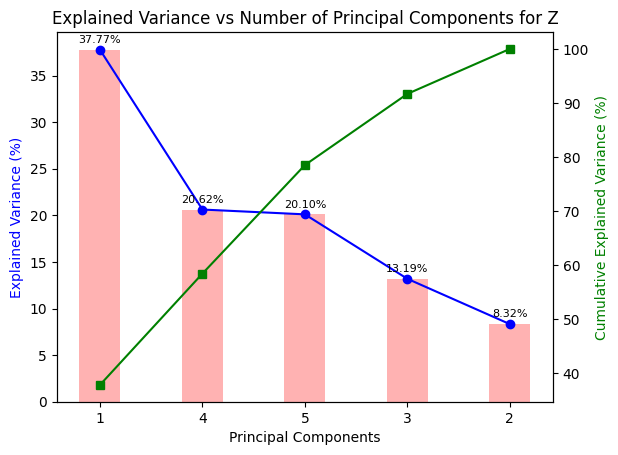

Feature vector for Z:
[[-0.57311893  0.48432346 -0.25670988  0.06772139]
 [-0.62260602  0.21014416  0.02996793  0.05599516]
 [ 0.00589601 -0.11497825  0.12720389  0.98430205]
 [ 0.07460375 -0.23331158 -0.95122444  0.10185199]
 [-0.52753763 -0.80846517  0.11042277 -0.1142541 ]]
Principal Component(s) to keep for Z:
[1 3 4 5]


In [6]:
import matplotlib.pyplot as plt

# Create dictionaries to store explained variances, feature vectors, and kept indices
explained_variances = {}
feature_vectors = {}
kept_indices = {}

# Iterate over the items (key-value pairs) in the eigen_values dictionary
for dataset_key, eigen_values in eigen_values.items():
    total_sum = sum(eigen_values)

    # Sort eigenvalues and eigenvectors based on eigenvalues
    sorted_indices = np.argsort(eigen_values)[::-1]
    sorted_eigen_values = eigen_values[sorted_indices]
    sorted_eigen_vectors = eigen_vectors[dataset_key][:, sorted_indices]

    # Calculate explained variance and store in explained_variances dictionary
    explained_variance = [(ev / total_sum) * 100 for ev in sorted_eigen_values]
    explained_variances[dataset_key] = explained_variance

    # Calculate cumulative explained variance
    cumulative_explained_variance = np.cumsum(explained_variance)

    # Plot explained variances
    fig, ax1 = plt.subplots()
    line_plot = ax1.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', color='b')
    ax1.set_xlabel('Principal Components')
    ax1.set_ylabel('Explained Variance (%)', color='b')

    x_ticks = np.arange(1, len(explained_variance) + 1)
    bar_width = 0.4
    bar_plot = ax1.bar(x_ticks, explained_variance, width=bar_width, alpha=0.3, color='r')

    ax2 = ax1.twinx()
    cumulative_plot = ax2.plot(range(1, len(explained_variance) + 1), cumulative_explained_variance, marker='s', color='g')
    ax2.set_ylabel('Cumulative Explained Variance (%)', color='g')

    ax1.set_title(f'Explained Variance vs Number of Principal Components for {dataset_key}')
    ax1.set_xticks(x_ticks)
    ax1.set_xticklabels(sorted_indices + 1)

    for i, ev in enumerate(explained_variance):
        ax1.annotate(f'{ev:.2f}%', (i+1, ev), textcoords="offset points", xytext=(0,5), ha='center', fontsize=8)

    plt.show()

    # Determine the number of principal components based on the desired variance threshold
    desired_variance_threshold = 90
    num_components = np.argmax(cumulative_explained_variance >= desired_variance_threshold) + 1

    # Select the feature vector based on the determined number of principal components
    selected_feature_vector = sorted_eigen_vectors[:, :num_components]

    # Sort the kept feature indices and feature vector for consistency
    kept_feature_indices = sorted_indices[:num_components] + 1
    unsorted_feature_indices = np.argsort(kept_feature_indices)
    unsorted_feature_vector = selected_feature_vector[:, unsorted_feature_indices]
    unsorted_kept_indices = kept_feature_indices[unsorted_feature_indices]

    # Store the feature vector and kept indices in the respective dictionaries
    feature_vectors[dataset_key] = unsorted_feature_vector
    kept_indices[dataset_key] = unsorted_kept_indices

    # Print the feature vector and kept indices
    print(f"Feature vector for {dataset_key}:")
    print(unsorted_feature_vector)
    print(f"Principal Component(s) to keep for {dataset_key}:")
    print(unsorted_kept_indices)


__Recasting Data Along Principal Components Axes in PCA__

Recasting the data along the principal components axes involves transforming the cleaned data using the selected feature vector obtained from PCA. It projects the data onto a new coordinate system defined by the principal components, preserving important patterns and variations. The resulting dataset represents data points' projections onto the principal components axes, simplifying analysis and visualization.

In [11]:
# Iterate over the datasets in the dataset dictionary
for axis, data in dataset.items():
    # Get the corresponding feature vector for the current axis
    feature_vector = feature_vectors[axis]
    
    # Perform the recasting by multiplying the data with the feature vector
    recasted_data = pd.DataFrame(np.dot(data.values, feature_vector), columns=data.columns[kept_indices[axis]-1])

    # Save the recasted data to a CSV file based on the axis
    if axis == 'X':
        recasted_data.to_csv('x_axis_transformed_data.csv', index=False)
    elif axis == 'Y':
        recasted_data.to_csv('y_axis_transformed_data.csv', index=False)
    
    # Print the recasted dataset for the current axis
    print(f"Recasted dataset for {axis}:")
    print(recasted_data.head(3).to_string(index=False))
    print()

Recasted dataset for X:
 HUMAN PLAYER POSITION (Y) metres  INITITAL VELOCITY OF SHUTTELCOCK(m/s)  SHUTTELCOCK SLANT ANGLE TO SIDELINE(DEGREE)  SHUTTLECOCK POSITIION IN AIR(Y) metres  SHUTTLECOCK POSITIION IN AIR(Z) metres
                        -4.837045                              30.907268                                     2.499698                                4.731528                               11.252237
                        -4.843049                              30.933574                                     2.518836                                4.794662                               11.184452
                        -4.849223                              30.960522                                     2.537982                                4.858073                               11.115496

Recasted dataset for Y:
 INITIAL SHUTTELCOCK FIRING ANGLE (DEGREE)  SHUTTELCOCK SLANT ANGLE TO SIDELINE(DEGREE)  SHUTTLECOCK POSITIION IN AIR(X) metres  SHUTTLECOCK POSITIION IN AIR(Y